# Searching for Dark Matter in ATLAS Proton-Proton Experiments Using Genetic Algorithms

#### Rohan Arni

In [4]:
import numpy as np
import pandas as pd
from deap import base, creator, tools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [5]:
dataset = pd.read_csv('data/data.csv')
subset_data = dataset.sample(n=1000, random_state=42)

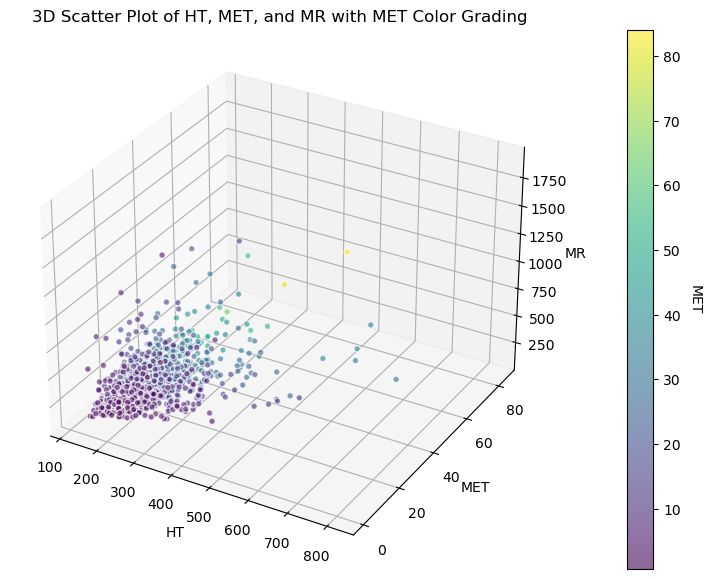

In [6]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(subset_data['HT'], subset_data['MET'], subset_data['MR'], c=subset_data['MET'], cmap='viridis', alpha=0.6, edgecolors='w')

ax.set_xlabel('HT')
ax.set_ylabel('MET')
ax.set_zlabel('MR')
ax.set_title('3D Scatter Plot of HT, MET, and MR with MET Color Grading')

cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('MET', rotation=270, labelpad=15)

plt.show()
